# PySpark ML Regression

In [1]:
import os
os.environ['SPARK_HOME'] = '/etc/spark/'
os.environ['HADOOP_HOME'] = '/etc/hadoop/'
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("yarn") \
        .appName("LR") \
        .getOrCreate()
sc = spark.sparkContext
sc

## Load and Explore data

In [4]:
# Load training data
pyspark_df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .csv("Housing.csv")

pyspark_df.show(5)

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+
only showing top 5 rows



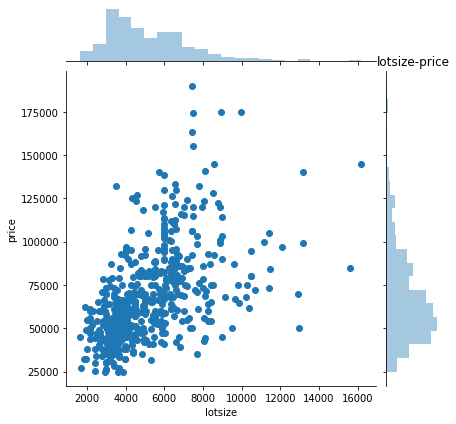

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

pandas_df = pyspark_df.toPandas()
# 'price' 컬럼이 object 타입으로 인식되는 문제가 있으므로 numeric으로 변경 
pandas_df['price'] = pd.to_numeric(pandas_df['price'])
sns.jointplot(x="lotsize", y="price", data=pandas_df)
plt.title("lotsize-price")
plt.show()

## Linear Regression only with "lotsize"

In [7]:
from pyspark.ml.feature import VectorAssembler

# use only one column 'size' 
training = VectorAssembler(inputCols=["lotsize"],
                           outputCol="features") \
                          .transform(pyspark_df)
training.show(5)

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|features|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|[5850.0]|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[4000.0]|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[3060.0]|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|[6650.0]|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[6360.0]|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------+
only showi

In [8]:
from pyspark.ml.regression import LinearRegression

# Create a model
lr = LinearRegression(featuresCol='features',
                      labelCol="price")

# Train the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)

# Objective function (scaled loss + regularization) at each iteration.
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [6.598767589265602]
Intercept: 34136.19156491504
numIterations: 1
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
| -30738.98196211882|
| -22031.26192197745|
|-4828.4203880677815|
|-17517.996033531294|
|-15104.353432644275|
+-------------------+
only showing top 5 rows

RMSE: 22525.681838
r2: 0.287077


## More: Use all numeric values

In [9]:
# include all numeric value
training2 = VectorAssembler(inputCols=["lotsize", "bedrooms", "bathrms", "stories"],
                            outputCol="features") \
                           .transform(pyspark_df)
training2.show(5)

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|            features|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+--------------------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|[5850.0,3.0,1.0,2.0]|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[4000.0,2.0,1.0,1.0]|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[3060.0,3.0,1.0,1.0]|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|[6650.0,3.0,1.0,2.0]|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|[6360.0,2.0,1.0,1.0]|
+---+-----+-------+-----

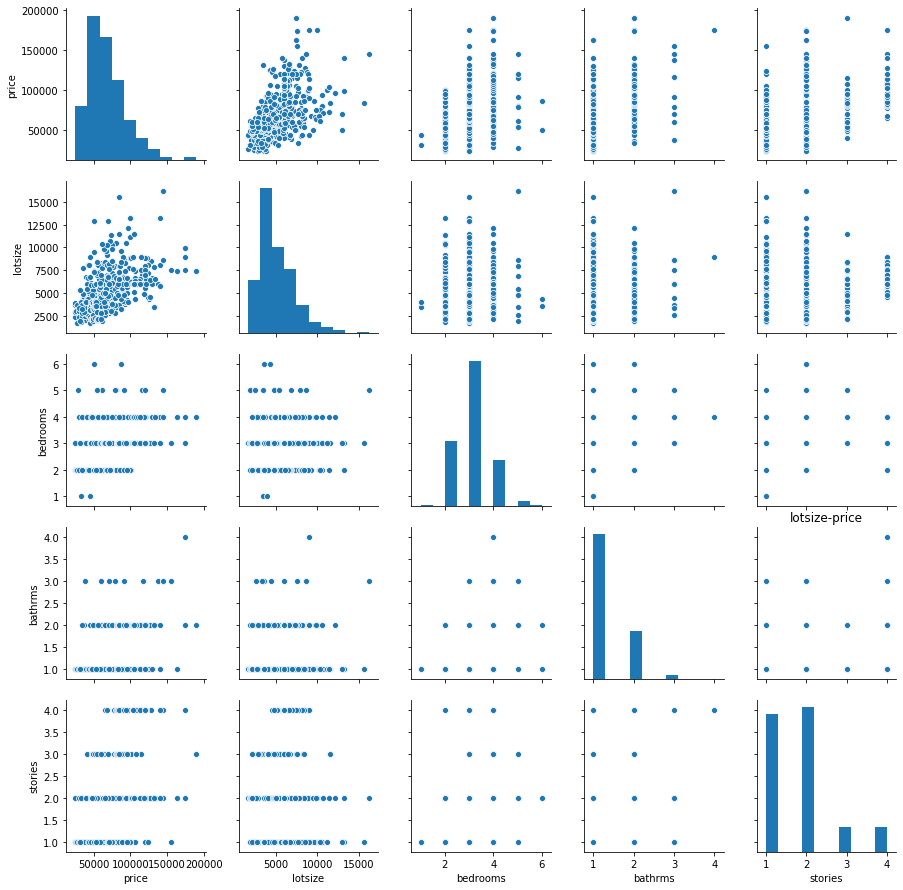

In [10]:
# draw pair plot
sns.pairplot(pandas_df[['price', 'lotsize', 'bedrooms', 'bathrms', 'stories']])
plt.title("lotsize-price")
plt.show()

In [11]:
# Train the model
lrModel2 = lr.fit(training2)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel2.coefficients))
print("Intercept: %s" % str(lrModel2.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary2 = lrModel2.summary
print("numIterations: %d" % trainingSummary2.totalIterations)

# Objective function (scaled loss + regularization) at each iteration.
print("objectiveHistory: %s" % str(trainingSummary2.objectiveHistory))
trainingSummary2.residuals.show(5)

print("RMSE: %f" % trainingSummary2.rootMeanSquaredError)
print("r2: %f" % trainingSummary2.r2)

Coefficients: [5.429173698420088,2824.613789572584,17105.1744567772,7634.897002828779]
Intercept: -4009.5499790134177
numIterations: 1
objectiveHistory: [0.0]
+------------------+
|         residuals|
+------------------+
|-26599.92598789661|
| -9596.44385341808|
|3682.3656335242194|
|-12443.26494663267|
| 90.70621831050812|
+------------------+
only showing top 5 rows

RMSE: 18181.402777
r2: 0.535547


## More: Use string values

In [12]:
# StringIndexer
from pyspark.ml.feature import StringIndexer

driveway_indexer = StringIndexer(inputCol="driveway", outputCol="drivewayIndex")
driveway_indexed_df = driveway_indexer.fit(pyspark_df).transform(pyspark_df)
driveway_indexed_df.show(5)

+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+-------------+
|_c0|price|lotsize|bedrooms|bathrms|stories|driveway|recroom|fullbase|gashw|airco|garagepl|prefarea|drivewayIndex|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+-----+--------+--------+-------------+
|  1|42000|   5850|       3|      1|      2|     yes|     no|     yes|   no|   no|       1|      no|          0.0|
|  2|38500|   4000|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|          0.0|
|  3|49500|   3060|       3|      1|      1|     yes|     no|      no|   no|   no|       0|      no|          0.0|
|  4|60500|   6650|       3|      1|      2|     yes|    yes|      no|   no|   no|       0|      no|          0.0|
|  5|61000|   6360|       2|      1|      1|     yes|     no|      no|   no|   no|       0|      no|          0.0|
+---+-----+-------+--------+-------+-------+--------+-------+--------+-----+----

In [13]:
driveway_indexer.fit(pyspark_df).labels

['yes', 'no']

In [14]:
# VectorAssembler
training3 = VectorAssembler(inputCols=["lotsize", "bedrooms", "bathrms", "stories", "drivewayIndex"],
                            outputCol="features") \
                           .transform(driveway_indexed_df)
training3.select(['price', "lotsize", "bedrooms", "bathrms", "stories", "drivewayIndex", "features"]) \
         .show(15, truncate=False)

+-----+-------+--------+-------+-------+-------------+------------------------+
|price|lotsize|bedrooms|bathrms|stories|drivewayIndex|features                |
+-----+-------+--------+-------+-------+-------------+------------------------+
|42000|5850   |3       |1      |2      |0.0          |[5850.0,3.0,1.0,2.0,0.0]|
|38500|4000   |2       |1      |1      |0.0          |[4000.0,2.0,1.0,1.0,0.0]|
|49500|3060   |3       |1      |1      |0.0          |[3060.0,3.0,1.0,1.0,0.0]|
|60500|6650   |3       |1      |2      |0.0          |[6650.0,3.0,1.0,2.0,0.0]|
|61000|6360   |2       |1      |1      |0.0          |[6360.0,2.0,1.0,1.0,0.0]|
|66000|4160   |3       |1      |1      |0.0          |[4160.0,3.0,1.0,1.0,0.0]|
|66000|3880   |3       |2      |2      |0.0          |[3880.0,3.0,2.0,2.0,0.0]|
|69000|4160   |3       |1      |3      |0.0          |[4160.0,3.0,1.0,3.0,0.0]|
|83800|4800   |3       |1      |1      |0.0          |[4800.0,3.0,1.0,1.0,0.0]|
|88500|5500   |3       |2      |4      |

In [15]:
# LinearRegression
lrModel3 = lr.fit(training3)
print("Coefficients: %s" % str(lrModel3.coefficients))
print("Intercept: %s" % str(lrModel3.intercept))

trainingSummary3 = lrModel3.summary
print("numIterations: %d" % trainingSummary3.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary3.objectiveHistory))
trainingSummary3.residuals.show(5)

print("RMSE: %f" % trainingSummary3.rootMeanSquaredError)
print("r2: %f" % trainingSummary3.r2)

Coefficients: [4.910113792921805,3387.039397487457,17280.734186948524,6981.640296974569,-10862.713732405862]
Intercept: -516.8702203397438
numIterations: 1
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
| -27612.42844161285|
|-11660.038230245482|
|  568.4293376135538|
|-13040.519475950292|
| -747.9067815409435|
+-------------------+
only showing top 5 rows

RMSE: 17825.941950
r2: 0.553531
